In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os
from pathlib import Path
import folium
from folium.plugins import HeatMap
from IPython.display import HTML

## Data Prep

In [2]:
# Define the base directory where your data is located
current_dir = Path.cwd()
print(current_dir)
data = (Path(current_dir) / "data").resolve()
# Paths for the shapefiles
divisions_path = os.path.join(data, "USA_Divisions", "usa_divisions.shp")
counties_path = os.path.join(data, "USA_Counties", "usa_counties.shp")
states_path = os.path.join(data, "USA_States", "usa_states.shp")

# Reading the shapefiles using geopandas
divisions = gpd.read_file(divisions_path)
counties = gpd.read_file(counties_path)
states = gpd.read_file(states_path)

/Users/jackrickey/Dev/Hot-Cold-Simulation


In [3]:
print(divisions)

             division                                           geometry
0         New England  MULTIPOLYGON (((-71.67381 41.17886, -71.67281 ...
1     Middle Atlantic  POLYGON ((-75.01591 38.79016, -75.01611 38.790...
2  East North Central  POLYGON ((-91.16348 40.64893, -91.15913 40.651...
3  West North Central  POLYGON ((-91.41982 40.37791, -91.42018 40.377...
4      South Atlantic  MULTIPOLYGON (((-82.97774 24.65649, -82.96410 ...
5  East South Central  POLYGON ((-90.95847 34.12511, -90.95925 34.128...
6  West South Central  POLYGON ((-91.16605 33.00314, -91.16620 33.002...
7            Mountain  POLYGON ((-103.00234 36.99966, -103.00234 36.9...
8             Pacific  MULTIPOLYGON (((-118.66386 33.06685, -118.6543...


In [4]:
print(states.columns)

Index(['FID', 'REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS',
       'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


In [5]:
print(counties["CROP_ACR17"].describe())

count    4.437000e+03
mean     1.294499e+05
std      1.526784e+05
min      0.000000e+00
25%      2.305400e+04
50%      7.243500e+04
75%      1.917800e+05
max      1.309653e+06
Name: CROP_ACR17, dtype: float64


Creating Counties DataFrame

In [6]:
counties_df = pd.DataFrame()
counties_df["FIPS"] = counties["FIPS"]
counties_df["x1"] = counties["POP_SQMI"]
counties_df["x2"] = counties["OWNER_OCC"] / counties["RENTER_OCC"]
counties_df["x3"] = counties["CROP_ACR17"]
counties_df["geometry"] = counties["geometry"]

Preparing State and Divisions dataframes

In [7]:
states_df = pd.DataFrame()
states_df["FIPS"] = states["STATEFP"]
states_df["geometry"] = states["geometry"]

divisions_df = pd.DataFrame()
divisions_df["FIPS"] = divisions.index
divisions_df["geometry"] = divisions["geometry"]

In [8]:
# Assuming 'states' and 'divisions' are already defined and have geometry information

# Convert 'states_df' to a GeoDataFrame
states_df = pd.DataFrame()
states_df["FIPS"] = states["STATEFP"]
states_df["geometry"] = states["geometry"]
states_gdf = gpd.GeoDataFrame(states_df, geometry="geometry")

counties_gdf = gpd.GeoDataFrame(counties_df, geometry="geometry")

# Convert 'divisions_df' to a GeoDataFrame
divisions_df = pd.DataFrame()
divisions_df["FIPS"] = divisions.index
divisions_df["geometry"] = divisions["geometry"]
divisions_gdf = gpd.GeoDataFrame(divisions_df, geometry="geometry")

# Ensure they have the correct coordinate reference system (CRS)
# Example: setting to WGS 84 (EPSG:4326)
states_gdf.crs = "EPSG:4326"
divisions_gdf.crs = "EPSG:4326"

# Now you can perform spatial operations on 'states_gdf' and 'divisions_gdf'

In [9]:
# Spatial join Counties with States
states_counties = gpd.sjoin(counties_gdf, states_gdf, how="inner", op="within")
print(states_counties.columns)
# Aggregate/Average Data for States
states_agg = (
    states_counties.groupby("FIPS_right")
    .agg(
        x1=("x1", "mean"),  # Average population density
        x2=(
            "x2",
            "mean",
        ),  # Average owner/renter ratio
        x3=("x3", "sum"),  # Sum of crop acreage
    )
    .reset_index()
)

# Spatial join Counties with Divisions
divisions_counties = gpd.sjoin(counties_gdf, divisions_gdf, how="inner", op="within")

# Aggregate/Average Data for Divisions
divisions_agg = (
    divisions_counties.groupby("FIPS_right")
    .agg(
        x1=("x1", "mean"),
        x2=("x2", "mean"),
        x3=("x3", "sum"),
    )
    .reset_index()
)

/Users/jackrickey/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Index(['FIPS_left', 'x1', 'x2', 'x3', 'geometry', 'index_right', 'FIPS_right'], dtype='object')


/Users/jackrickey/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [10]:
states_agg["geometry"] = states["geometry"]
states_agg["names"] = states["NAME"]
states_agg = states_agg.rename(columns={"FIPS_right": "FIPS"})
divisions_agg["geometry"] = divisions["geometry"]
divisions_agg["names"] = divisions["division"]
divisions_agg = divisions_agg.rename(columns={"FIPS_right": "FIPS"})

Renaming

In [11]:
counties = counties_df
states = states_agg
divisions = divisions_agg

In [12]:
print(counties)
print(states)
print(divisions)

       FIPS     x1        x2        x3  \
0     01001   96.3  3.066157   36890.0   
1     01003  139.4  2.639167  110438.0   
2     01005   29.1  2.008578   37304.0   
3     01007   36.8  3.095263   15823.0   
4     01009   92.2  4.144969   43793.0   
...     ...    ...       ...       ...   
4432  46063    0.5  2.769231  184604.0   
4433  46089    2.1  4.338542  383940.0   
4434  46091    5.9  2.789144  343430.0   
4435  46105    1.0  2.972308  347672.0   
4436  46109    9.6  2.209908  451658.0   

                                               geometry  
0     POLYGON ((-86.41312 32.70739, -86.41300 32.678...  
1     MULTIPOLYGON (((-87.56491 30.28162, -87.56470 ...  
2     POLYGON ((-85.25784 32.14794, -85.25851 32.146...  
3     POLYGON ((-87.06574 33.24691, -87.06477 33.246...  
4     POLYGON ((-86.45302 34.25932, -86.45288 34.259...  
...                                                 ...  
4432  POLYGON ((-102.99526 45.94517, -102.98992 45.9...  
4433  POLYGON ((-99.61455 45.94

## Stochastic Model

In [13]:
def logistic_function_with_noise_normalized(x1, x2, x3, a, b, y, sigma, steps=100):
    """
    Generate stochastic paths using a logistic function with added noise, and normalize
    the results to get probabilities that sum to 1.

    Parameters:
    - x1, x2, x3: Variables for population density, owner/renter ratio, and crop acreage.
    - a, b, y: Parameters weighting the importance of x1, x2, and x3.
    - sigma: Standard deviation of the noise term.
    - steps: Number of steps in the stochastic path.

    Returns:
    - A numpy array containing normalized probabilities for each step.
    """
    path = np.zeros(steps)
    for i in range(steps):
        e = np.random.normal(0, sigma**2)  # Noise term
        logistic_val = 1 / (1 + np.exp(-(a * x1 + b * x2 + y * x3)))
        path[i] = logistic_val + e

    # Normalize the path to ensure the sum of probabilities equals 1
    normalized_path = np.maximum(path, 0)  # Ensure all probabilities are non-negative
    sum_path = np.sum(normalized_path)
    if sum_path > 0:
        normalized_path = normalized_path / sum_path
    else:
        # In case sum_path is 0 or negative due to noise, distribute probabilities evenly
        normalized_path = np.ones(steps) / steps

    return normalized_path

In [14]:
def generate_stochastic_paths_df(gdf, a, b, y, sigma):
    data_for_new_df = []
    for index, row in gdf.iterrows():
        path = logistic_function_with_noise_normalized(
            row["x1"], row["x2"], row["x3"], a, b, y, sigma
        )
        data_for_new_df.append({"FIPS": row["FIPS"], "stochastic_paths": path.tolist()})
    return pd.DataFrame(data_for_new_df)

In [15]:
def plot_pdf_for_steps(stochastic_paths_df, name, steps_to_plot=[0, 49, 99]):
    all_paths = np.array(stochastic_paths_df["stochastic_paths"].tolist())
    transposed_paths = (
        all_paths.T
    )  # Transpose so each row represents a step across all paths

    # Step 2: Plot the PDF for each step
    steps_to_plot = [
        0,
        49,
        99,
    ]  # For example, plot the PDF for the first, middle, and last step
    for step in steps_to_plot:
        probabilities = transposed_paths[step]

        # Compute the histogram
        density, bins = np.histogram(probabilities, bins=30, density=True)
        # Compute bin centers
        bin_centers = (bins[:-1] + bins[1:]) / 2

        # Plot the PDF
        plt.plot(bin_centers, density, label=f"Step {step + 1}")

    plt.xlabel("Probability")
    plt.xticks(rotation=45)  # Rotate labels to prevent overlap
    plt.ylabel("Density")
    plt.title(f"Probability Density Function for {name} at Selected Steps")
    plt.legend()
    plt.show()

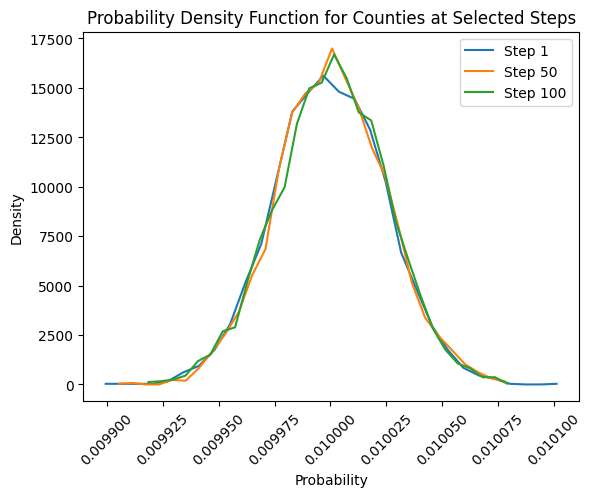

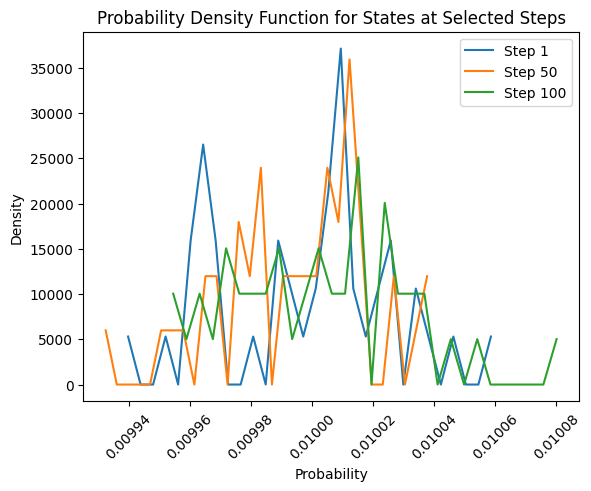

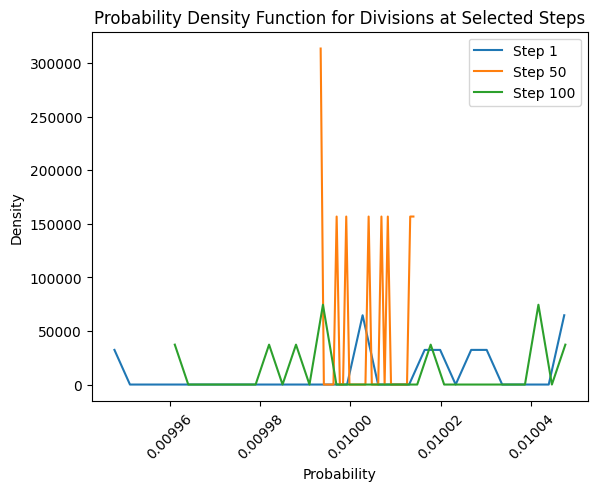

In [16]:
# Example parameters
a, b, y, sigma = 0.1, 0.2, 0.3, 0.05

# Generate stochastic paths DataFrame for counties
counties_stochastic_df = generate_stochastic_paths_df(counties, a, b, y, sigma)
# Plot PDF for counties
plot_pdf_for_steps(counties_stochastic_df, name="Counties")

# Repeat similarly for states and divisions
states_stochastic_df = generate_stochastic_paths_df(states, a, b, y, sigma)
plot_pdf_for_steps(states_stochastic_df, name="States")

divisions_stochastic_df = generate_stochastic_paths_df(divisions, a, b, y, sigma)
plot_pdf_for_steps(divisions_stochastic_df, name="Divisions")

heatmap

Time zero heatmap

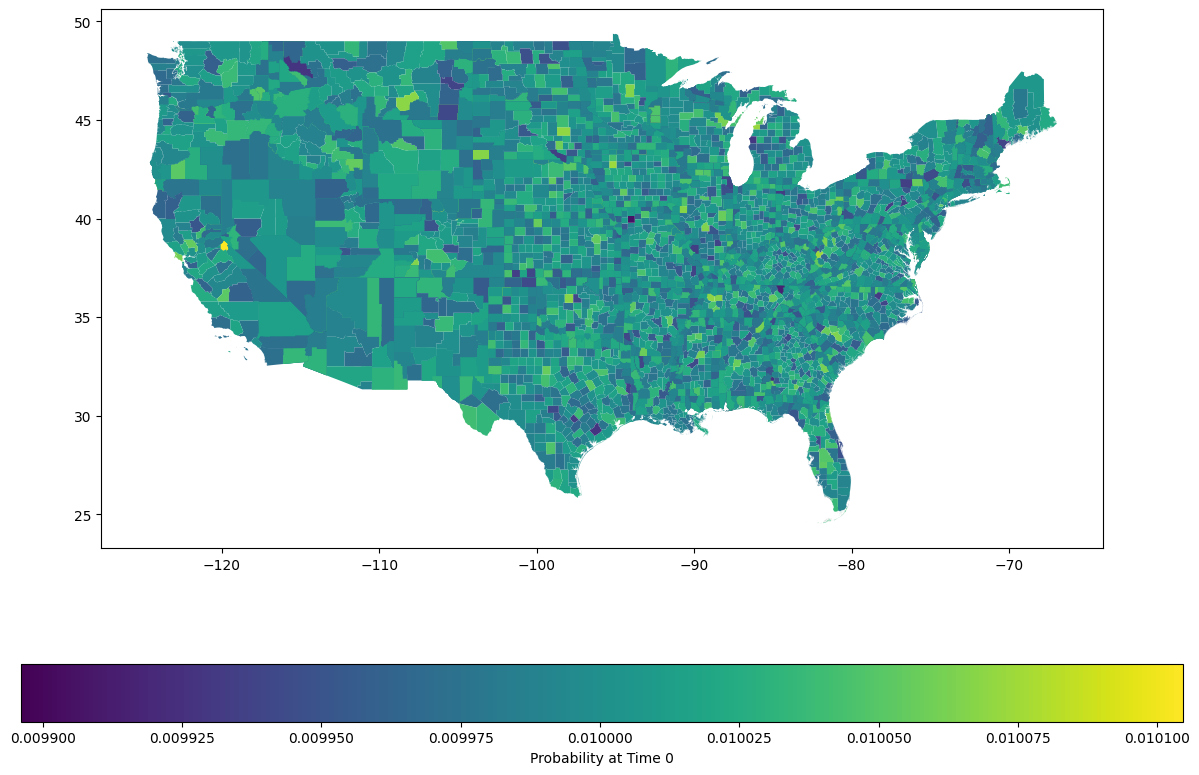

In [35]:
df = pd.DataFrame()
df["FIPS"] = counties_stochastic_df["FIPS"]
df["time_0_probs"] = counties_stochastic_df["stochastic_paths"].apply(lambda x: x[0])
merged_gdf = counties_gdf.merge(df, on="FIPS")
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

merged_gdf.plot(
    column="time_0_probs",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Probability at Time 0", "orientation": "horizontal"},
)
plt.show()

In [18]:
%matplotlib inline

In [38]:
df = pd.DataFrame()
df["FIPS"] = counties_stochastic_df["FIPS"]
df["stochastic_paths"] = counties_stochastic_df["stochastic_paths"]
merged_gdf = counties_gdf.merge(df, on="FIPS")
merged_gdf.set_crs(counties_gdf.crs, inplace=True)

,FIPS,x1,x2,x3,geometry,stochastic_paths
0,01001,96.3,3.066157,36890.0,"POLYGON ((-86.41312 32.70739, -86.41300 32.678...","[0.010035106739664162, 0.010000437082042991, 0..."
1,01003,139.4,2.639167,110438.0,"MULTIPOLYGON (((-87.56491 30.28162, -87.56470 ...","[0.009932567314210475, 0.010010535676561298, 0..."
2,01003,139.4,2.639167,110438.0,"MULTIPOLYGON (((-87.56491 30.28162, -87.56470 ...","[0.01002327267632055, 0.009991417515767997, 0...."
3,01003,139.4,2.639167,110438.0,"MULTIPOLYGON (((-87.56491 30.28162, -87.56470 ...","[0.009932567314210475, 0.010010535676561298, 0..."
4,01003,139.4,2.639167,110438.0,"MULTIPOLYGON (((-87.56491 30.28162, -87.56470 ...","[0.01002327267632055, 0.009991417515767997, 0...."
...,...,...,...,...,...,...
7502,38091,2.9,4.400000,398585.0,"POLYGON ((-97.92533 47.67228, -97.92526 47.672...","[0.009994347295984519, 0.009991574695752828, 0..."
7503,38093,9.3,2.003026,1048238.0,"POLYGON ((-99.26674 47.32720, -99.26622 47.327...","[0.010010598098584345, 0.009984801595584692, 0..."
7504,38095,2.1,3.295082,552379.0,"POLYGON ((-99.00017 48.72549, -98.99990 48.718...","[0.009983979705096761, 0.010001118071931783, 0..."
7505,38101,35.0,1.747722,967455.0,"POLYGON ((-102.13121 48.80721, -102.12921 48.8...","[0.010036729939330769, 0.009981941765702659, 0..."


In [39]:
# Initialize the figure for animation
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_xlim(-127, -64)  # Set these based on your specific geographic extents
ax.set_ylim(22, 52)


def update(frame):
    ax.clear()  # Clear existing content on the axes
    # Prepare data for the current frame
    df["time_step_probs"] = counties_stochastic_df["stochastic_paths"].apply(
        lambda x: x[frame]
    )
    merged_gdf = counties_gdf.merge(df, on="FIPS")

    # Plotting current time step probabilities
    merged_gdf.plot(
        column="time_step_probs",
        ax=ax,
        legend=True,
        legend_kwds={
            "label": f"Probability at Time {frame}",
            "orientation": "horizontal",
        },
        cmap="viridis",  # You can change the colormap to whatever you prefer
    )
    ax.set_title(f"Time Step: {frame}")
    ax.set_xlim(-127, -64)
    ax.set_ylim(22, 52)
    return (ax,)


# Total number of frames is the length of the stochastic path for any county
num_frames = len(counties_stochastic_df["stochastic_paths"][0])

ani = FuncAnimation(fig=fig, func=update, frames=num_frames, repeat=False)

# To display the animation in the notebook
plt.close(fig)  # This prevents an extra empty plot from showing in the notebook
from IPython.display import HTML

HTML(ani.to_jshtml())

ValueError: bottom cannot be >= top

<Figure size 640x480 with 0 Axes>

Saving

In [ ]:
# Define the directory to save the shapefiles
save_dir = Path.cwd() / "stochastic_paths"
save_dir.mkdir(exist_ok=True)  # Create the directory if it doesn't exist


# Function to save GeoDataFrames to the specified directory
def save_gdf(gdf, name, directory=save_dir):
    """
    Save a GeoDataFrame as a shapefile in the specified directory.

    Parameters:
    - gdf: The GeoDataFrame to save.
    - name: The name for the saved file (without extension).
    - directory: The directory where the shapefile will be saved.
    """
    file_path = directory / f"{name}.csv"
    gdf.to_csv(file_path, index=False)


# Save the GeoDataFrames
save_gdf(counties_stochastic_df, "counties_stochastic")
save_gdf(states_stochastic_df, "states_stochastic")
save_gdf(divisions_stochastic_df, "divisions_stochastic")